In [338]:
#Neural Network!!
import random
from micrograd.engine import Value

class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [339]:
#Enigine of micrograd library
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [340]:
from micrograd.engine import Value

a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
print(f'{g.data:.4f}') # prints 24.7041, the outcome of this forward pass
g.backward()
print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db

24.7041
138.8338
645.5773


In [341]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [342]:
#Function to return 3x2 - 4x + 5
def f(x):
    return (3*x**2 - 4*x + 5)

In [343]:
f(3.0)

20.0

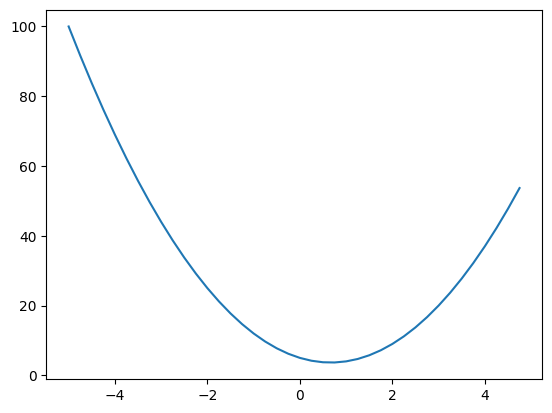

In [344]:
#Parabolic Function
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [345]:
#To ge the derivative of function
#Slope of a function
h=0.000000001
x  = -3.0
(f(x+h) - f(x))/h

-22.000001820288162

In [346]:
#Convergence
h=0.000000001
x  = 2/3
(f(x+h) - f(x))/h

0.0

In [347]:
#More complex case : Partial Derevatives wrt a,b and c
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)


4.0


In [348]:
#Partial Derivative
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c

a+=h

d2 = a*b+c
print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h) #Negative slope, because b is negative

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [349]:
#Partial Derivative
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c

b+=h

d2 = a*b+c
print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h) #Positive slope, because b is negative and if b is pushed to be a little positive

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [350]:
#Takes a single scalar value that it keeps track of
class Value:
    def __init__(self,data): #initializing the data (mainly a and b)
        self.data = data
    def __repr__(self): #function used to return the datatype we are familer with other wise it will return the address at which output is present
        return f"value(data={self.data}"
    def __add__(self,other):  # Operator function to add the values (Values here is a datatype by which we can easily use and visualize back propogation)
        out = Value(self.data + other.data) 
        return out
    def __mul__(self,other):  # Operator function to multiply the values (Values here is a datatype by which we can easily use and visualize back propogation)
        out = Value(self.data * other.data) 
        return out

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
g = (a+b) #Will show error if we don't have the operator function
f = (a*b)
d = (a*b) + c #Full operation
d

value(data=4.0

In [351]:
class Value:
    def __init__(self,data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 #By this we assume that every value(a,b,c,d,e etc) does not affect the loss funtion
        self._backward = lambda : None #By default doesn't do amything 
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self): 
        return f"Value(data={self.data}, grad={self.grad})"
    def __add__(self,other):  
        other = other if isinstance(other,Value) else Value(other) #This will help in scalar addition and multiplication on the defined variable "other"
        out = Value(self.data + other.data, (self,other), '+') 

        def _backward() :
            self.grad += 1.0 * out.grad #Accumilating gradintes to perform multivarite (Where the varible is dependent on one or more variable)
            other.grad += 1.0 * out.grad # Like we saw in back prop, after adding the two neurons, we will perform local derivative * global derivative
            
        out._backward = _backward
        
        return out
    def __mul__(self,other):  
        other = other if isinstance(other,Value) else Value(other) #This will help in scalar addition and multiplication on the defined variable "other"
        out = Value(self.data * other.data, (self,other), '*') 
    
        def _backward():
            self.grad += (other.data) * out.grad
            other.grad += self.data * out.grad #Chain rule

        out._backward = _backward    
        return out
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self,other):
        return self * other # To effectively perform scalar multiplication
        
    def tanh(self):
        x= self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self): #To calculate exponentials
        x = self.data
        out = Value(math.exp(x),(self,),'exp')
        def _backward():
            self.grad+=out.data * out.grad
        out._backward = _backward

        return out
        
    def backward(self): #Back propogation trhough topolocil sort
        #Topological sorting: we do this to order the graph such that nodes only go from left to right
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self) # start from this node
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    def __neg__(self): # -self
        return self * -1
    def __sub__(self, other): # self - other
        return self + (-other)
    def __rsub__(self, other): # other - self
        return Value(other) + (-self)
    def __radd__(self, other):
        return self + other
# children will be a set or a tuple(right now), we use this for efficiency. 
# When we want to add children, we can feed in the children as a parameter(self,oter)
# _op i the operation that created children

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
q = (a*b) + c #Full operation
f = Value(-2.0,label = 'f')
L = d*f; L.label = 'L'
L

Value(data=-8.0, grad=0.0)

In [352]:
d._prev

{Value(data=-6.0, grad=0.0), Value(data=10.0, grad=0.0)}

In [353]:
d._op

'+'

In [354]:
#Visualizing the operations and children of our function using graphviz api
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{  %s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad), shape='record') #| grad %.4f 
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

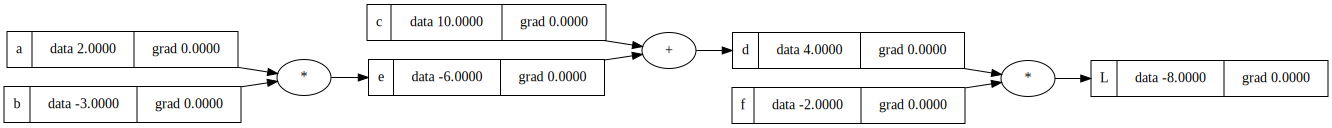

In [355]:
draw_dot(L)
#After this, we will perform backpropogation by finding the gradient in each step by calculating partial derivatives with respect to L

In [356]:
#df/dL = d(f*d)/df=d. Therefore f.grad = d and d.grad =f
f.grad = 4.0
d.grad = -2.0  
# # Derivative of c and e will be calculated by the chain rule hence (dl/dc = dl/dd * dd/dc) => therefore c grad = -2.0 * 1.0 = -2.0
# # since d = c+e, putting it in the function f(x+h)-f(x)/h
# # Just like dL/dc = -2.0 dL/de = -2.0
c.grad = -2.0
e.grad = -2.0
# #dL/da = dL/dc * dc/da 
# # da and db again will be calculatd via chain rule.
a.grad = 6.0
b.grad = -4.0

In [357]:
###Optimizing steps to change the direction of loss function L!
# a.data += 0.01 + a.grad
# b.data += 0.01 + b.grad
# c.data += 0.01 + c.grad
# f.data += 0.01 + f.grad

# e = a * b
# d = e + c
# L = d * f

# print(L.data) Will change L to -7.9!

In [358]:
#We do this to not mess up the scope of these variables
# So this is to calculate the derivatives of each varible with respect to L
def lol():
    h=0.001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    q = (a*b) + c #Full operation
    f = Value(-2.0,label = 'f')
    L = d*f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0, label='a')
    a.data+=h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    q = (a*b) + c #Full operation
    f = Value(-2.0 ,label = 'f')
    L = d*f; L.label = 'L'
    L2 = L.data 

    print((L2-L1)/h) #This is the derivative wrt to A

lol()

6.000000000000227


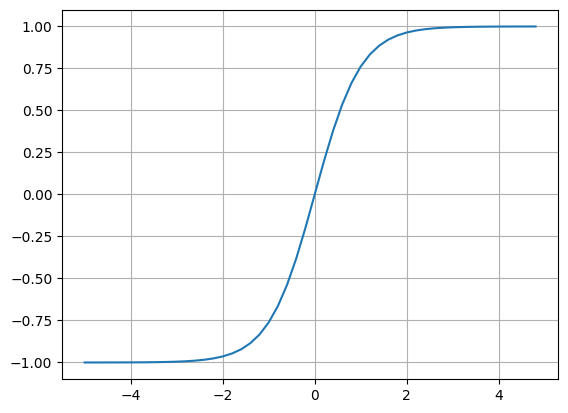

In [359]:
#Back Propogating through a neuron using the tanh function It is like a sigmoid

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [360]:
# inputs x1 and x2, weights w1 w2 and bias b
# this is a cs231n neuron
# n is the raw activation function of inputs, weights and biases

x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

b = Value(6.8813735870195432,label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label ='x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



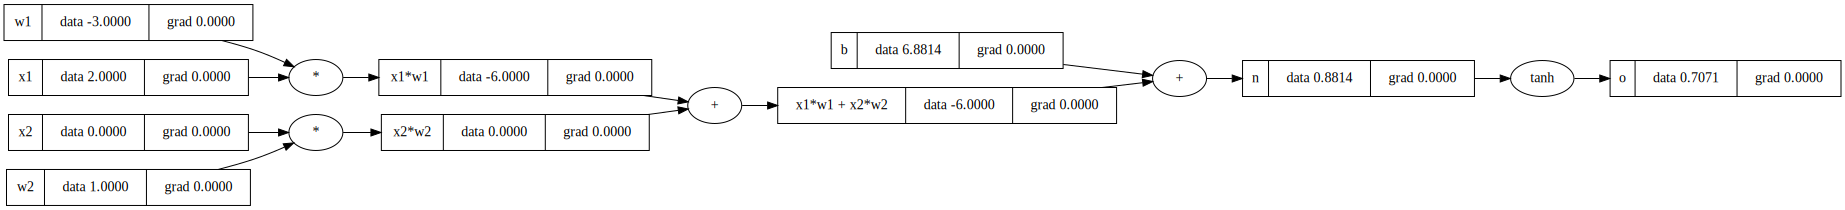

In [361]:
draw_dot(o)

In [362]:
o.backward()

In [363]:
# o.grad = 1.0
# n.grad = 0.5
# x1w1x2w2.grad = 0.5
# b.grad = 0.5
# x1w1.grad = 0.5
# x2w2.grad = 0.5

# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad

# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()

In [364]:
1-o.data**2 # This will be equal to n.grad, xqwqx2w2=x1w1=x2w2 since the operation is +

0.4999999999999999

In [365]:
# Again, to backpropogate through tanh, we must find the local derivatives/partial derevatives of tanh
# do/dn = 1 - tanh(n)**2 = 1 - o **2

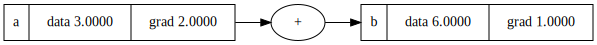

In [366]:
#Problem in our current back propogation method in the class Value, we are setting self.grad to 1.0 and others.grad to 1.0 which is causing the bug in this function
a = Value(3.0,label = 'a') # The grad should be 1.0
b = a+a ; b.label = 'b' #The grad should be 2.0
b.backward()
draw_dot(b)

In [367]:
#In the current function definition, we cannot add or multiply a scalar value to a defined 'self' value
a = Value(2.0)
a+2
a*2
2*a

Value(data=4.0, grad=0.0)

In [368]:
a.exp()

Value(data=7.38905609893065, grad=0.0)

In [369]:
# Division of a/b will be equal to a * (b**-1)

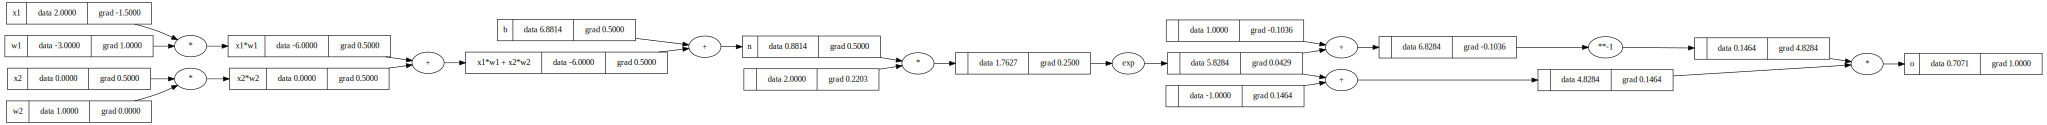

In [370]:
# inputs x1 and x2, weights w1 w2 and bias b
# this is a cs231n neuron
# n is the raw activation function of inputs, weights and biases

x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')

b = Value(6.8813735870195432,label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label ='x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

# o = n.tanh(); o.label = 'o'

# -----------------
# Defining the tanh without using tanh function(in built)
e = (2*n).exp()
o = (e-1)/(e+1); o.label = 'o'

# recompute loss or grads if needed; demonstrate backward works
o.backward()
draw_dot(o)


In [371]:
import torch

In [372]:
# Building the neural net using pytorch
# We define all the value objects like we did earlier, since our netwrok was taking only scalar values, we didn't initialize vector values.
# Therefore in pytorch, we will utilize its tensors.
# We have to explicitly define that these tensors require gradients
# We then perform arithmatic
# As we know, neural net is just a specific class of mathematical expression performed 
# Building multi layer perceptron (MLP)
# In the class of neuron, we initialize the weights, and biases
# To forward a single neuron(To perform calculations and back propogation on a single neuron) we use call function which w*x + b where w is the wieght, x is the input, b is the bias
# To initalize a layer of neurons, we just initialize a list of those neurons

In [373]:
#initializing tensors
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [374]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [375]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.434959546415116, grad=0.0)

In [376]:
len(n.parameters())

41

In [377]:
n.parameters()

[Value(data=-0.8783893934633018, grad=0.0),
 Value(data=-0.6411753343672899, grad=0.0),
 Value(data=0.02042672091339548, grad=0.0),
 Value(data=-0.24768282554604615, grad=0.0),
 Value(data=-0.9711771405311538, grad=0.0),
 Value(data=-0.46434681337979433, grad=0.0),
 Value(data=-0.7428182025428034, grad=0.0),
 Value(data=-0.09507997412045555, grad=0.0),
 Value(data=0.9449141810998505, grad=0.0),
 Value(data=0.9828828272146102, grad=0.0),
 Value(data=0.2181369866879932, grad=0.0),
 Value(data=0.5546909857746269, grad=0.0),
 Value(data=-0.7672137744189684, grad=0.0),
 Value(data=-0.09171051730044244, grad=0.0),
 Value(data=0.7173965483068945, grad=0.0),
 Value(data=0.18956411300698162, grad=0.0),
 Value(data=-0.7750500162238327, grad=0.0),
 Value(data=0.6530286950260273, grad=0.0),
 Value(data=0.3797257139538235, grad=0.0),
 Value(data=0.36877582329950087, grad=0.0),
 Value(data=-0.44297766263402294, grad=0.0),
 Value(data=-0.3846219364517012, grad=0.0),
 Value(data=0.19867330282552853, g

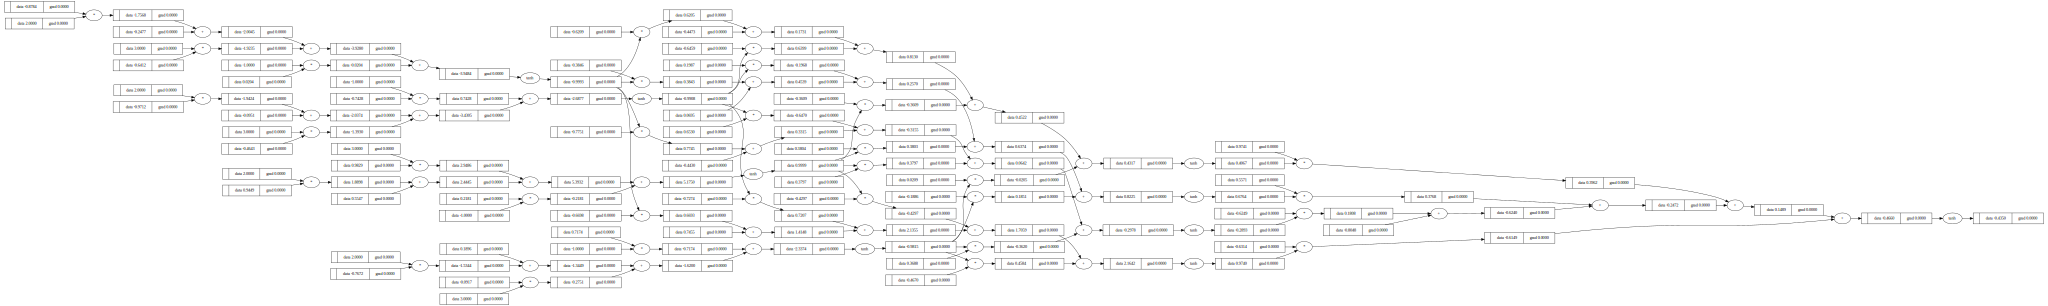

In [378]:
draw_dot(n(x))

In [379]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [387]:
# Fine tune to get the desired targets
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) #Performing loss to get a comparative analysis with respect to desired output and outputs we are getting
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward() # Getting the gradients of each parameter
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad #updating their gradients to minimize the loss. That's why we add -0.1
  
  print(k, loss.data)


0 0.0038820737716810756
1 0.0038221860025679155
2 0.0037640688179555997
3 0.0037076458203352137
4 0.003652844912452693
5 0.0035995980004420837
6 0.0035478407211299804
7 0.0034975121912518975
8 0.0034485547765590154
9 0.0034009138790035654
10 0.003354537740376755
11 0.00330937726093844
12 0.003265385831723009
13 0.0032225191793367105
14 0.0031807352221770056
15 0.0031399939371072856
16 0.00310025723571347
17 0.0030614888493501954
18 0.0030236542222587563
19 0.0029867204121050133


In [388]:
ypred = (n(x) for x in xs)
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) #In GPT, they mostly use entropy
loss

Value(data=0.002950655997344592, grad=0.0)

In [386]:
ypred

<generator object <genexpr> at 0x794f7e7a1be0>